In [1]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json # Untuk menyimpan mapping kelas

# Library TensorFlow dan Keras untuk membangun dan melatih model CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Untuk Transfer Learning (sangat direkomendasikan untuk proyek ini)
from tensorflow.keras.applications import ResNet50V2 # Anda bisa coba MobileNetV2 atau EfficientNetB0 juga

# Untuk membagi data menjadi set pelatihan dan pengujian
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # Untuk laporan evaluasi

# Untuk mengakses dataset dari Kaggle secara programatis
import kagglehub

# Pastikan TensorFlow mendeteksi GPU Anda
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# --- Unduh Dataset Menggunakan kagglehub ---
print("\nMengunduh dataset Stanford Dogs dari Kaggle...")
# 'path_ke_dataset_root' akan berisi lokasi tempat dataset diunduh di lingkungan Kaggle Anda
path_ke_dataset_root = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print(f"Dataset berhasil diunduh ke: {path_ke_dataset_root}")

# Dataset Stanford Dogs memiliki folder gambar di dalam subdirektori 'images/Images'.
# Kita perlu membuat path lengkap ke folder gambar ini.
path_ke_gambar = os.path.join(path_ke_dataset_root, 'images', 'Images')

# Verifikasi apakah path ke folder gambar sudah benar
if not os.path.exists(path_ke_gambar):
    print(f"Error: Folder gambar tidak ditemukan di '{path_ke_gambar}'. Silakan periksa struktur dataset yang diunduh.")
else:
    print(f"Folder gambar ditemukan di: {path_ke_gambar}")

print("-" * 50)

2025-06-23 09:13:46.718859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750670027.119180      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750670027.234213      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU is available

Mengunduh dataset Stanford Dogs dari Kaggle...
Dataset berhasil diunduh ke: /kaggle/input/stanford-dogs-dataset
Folder gambar ditemukan di: /kaggle/input/stanford-dogs-dataset/images/Images
--------------------------------------------------


In [ ]:
print("Memulai pra-pemrosesan data gambar...")

# Kumpulkan semua path gambar dan label (nama ras)
image_paths = []
labels = []

# Iterasi melalui setiap folder ras anjing di dalam path_ke_gambar
for breed_folder in os.listdir(path_ke_gambar):
    breed_path = os.path.join(path_ke_gambar, breed_folder)
    if os.path.isdir(breed_path): # Pastikan ini adalah folder, bukan file lain
        # Nama ras ada setelah kode numerik, misal: 'n02085620-Chihuahua' -> 'Chihuahua'
        breed_name = breed_folder.split('-')[1]
        for img_name in os.listdir(breed_path):
            image_paths.append(os.path.join(breed_path, img_name))
            labels.append(breed_name)

# Buat DataFrame dari path dan label untuk memudahkan manajemen data
df = pd.DataFrame({'path': image_paths, 'label': labels})
print(f"Total gambar yang ditemukan: {len(df)}")
print(f"Jumlah ras anjing unik: {df['label'].nunique()}")

# --- Atur Parameter Gambar dan Batch ---
# Ukuran gambar akan diubah menjadi 224x224 piksel, standar untuk banyak model CNN
IMG_HEIGHT = 224
IMG_WIDTH = 224
# Jumlah gambar yang akan diproses sekaligus oleh model dalam satu iterasi pelatihan
BATCH_SIZE = 32
# Jumlah total kelas (ras anjing) yang akan diklasifikasikan
NUM_CLASSES = df['label'].nunique()

# --- Bagi Data Menjadi Training dan Testing Set ---
# Kita akan membagi data menjadi 80% untuk pelatihan dan 20% untuk pengujian.
# 'stratify=df['label']' memastikan bahwa distribusi setiap ras anjing di set pelatihan dan pengujian tetap mirip.
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"\nJumlah gambar untuk training: {len(train_df)}")
print(f"Jumlah gambar untuk testing: {len(test_df)}")

# --- Konfigurasi Data Augmentasi dan Generator Gambar ---
# ImageDataGenerator di Keras sangat powerful untuk:
# 1. Normalisasi piksel (mengubah nilai dari 0-255 menjadi 0-1)
# 2. Melakukan augmentasi data (rotasi, zoom, flip) pada data training untuk mencegah overfitting.
#    Ini menciptakan variasi baru dari gambar yang sudah ada, membuat model lebih robust.
# 3. Secara otomatis membuat batch gambar dari direktori atau DataFrame.
# 4. Memisahkan sebagian kecil dari data training untuk validasi (`validation_split`).

train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalisasi piksel
    rotation_range=20, # Rotasi gambar hingga 20 derajat
    width_shift_range=0.2, # Geser gambar secara horizontal hingga 20% lebar
    height_shift_range=0.2, # Geser gambar secara vertikal hingga 20% tinggi
    shear_range=0.2, # Transformasi shear
    zoom_range=0.2, # Zoom in/out gambar hingga 20%
    horizontal_flip=True, # Balik gambar secara horizontal
    fill_mode='nearest', # Cara mengisi piksel yang hilang setelah transformasi
    validation_split=0.2 # 20% dari 'train_df' akan digunakan sebagai data validasi
)

# Untuk data testing, kita hanya perlu normalisasi, tidak perlu augmentasi.
test_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator untuk training, validation, dan testing set dari DataFrame
# 'flow_from_dataframe' adalah metode yang cocok karena kita sudah memiliki DataFrame.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', # Kolom di DataFrame yang berisi path ke gambar
    y_col='label', # Kolom di DataFrame yang berisi label kelas (nama ras)
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Ukuran gambar output
    batch_size=BATCH_SIZE, # Jumlah gambar per batch
    class_mode='categorical', # Output label sebagai one-hot encoding (misal: [0,0,1,0,...] untuk 3rd class)
    subset='training', # Tentukan ini adalah subset 'training' dari split di atas
    shuffle=True, # Acak urutan gambar untuk pelatihan agar model tidak bias
    seed=42 # Seed untuk reproducibility
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', # Tentukan ini adalah subset 'validation'
    shuffle=False, # Tidak perlu diacak untuk validasi
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # PENTING: Jangan acak urutan untuk test set agar prediksi bisa dicocokkan dengan label asli
)


# 'train_generator.class_indices' menghasilkan mapping nama ras ke indeks (misal: {'Chihuahua': 0, 'Labrador': 1})
# Kita balik menjadi indeks ke nama ras (misal: {0: 'Chihuahua', 1: 'Labrador'})
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("\nMapping kelas (indeks angka ke nama ras):")
print(idx_to_class)

print("-" * 50)

Memulai pra-pemrosesan data gambar...
Total gambar yang ditemukan: 20580
Jumlah ras anjing unik: 120

Jumlah gambar untuk training: 16464
Jumlah gambar untuk testing: 4116
Found 13172 validated image filenames belonging to 120 classes.
Found 3292 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.

Mapping kelas (indeks angka ke nama ras):
{0: 'Afghan_hound', 1: 'African_hunting_dog', 2: 'Airedale', 3: 'American_Staffordshire_terrier', 4: 'Appenzeller', 5: 'Australian_terrier', 6: 'Bedlington_terrier', 7: 'Bernese_mountain_dog', 8: 'Blenheim_spaniel', 9: 'Border_collie', 10: 'Border_terrier', 11: 'Boston_bull', 12: 'Bouvier_des_Flandres', 13: 'Brabancon_griffon', 14: 'Brittany_spaniel', 15: 'Cardigan', 16: 'Chesapeake_Bay_retriever', 17: 'Chihuahua', 18: 'Dandie_Dinmont', 19: 'Doberman', 20: 'English_foxhound', 21: 'English_setter', 22: 'English_springer', 23: 'EntleBucher', 24: 'Eskimo_dog', 25: 'French_bulldog', 26: 'Germ

In [7]:
print("Membangun model CNN dengan Transfer Learning...")

# --- Pilih Model Dasar Pra-terlatih ---
# ResNet50V2 adalah pilihan yang kuat. Anda juga bisa mencoba MobileNetV2 atau EfficientNetB0.
# 'weights='imagenet'' berarti kita menggunakan bobot yang sudah dilatih pada dataset ImageNet (dataset besar).
# 'include_top=False' berarti kita tidak menyertakan lapisan klasifikasi terakhir dari model asli,
# karena kita akan menambahkan lapisan klasifikasi kita sendiri yang sesuai dengan jumlah ras anjing kita.
# 'input_shape' harus sama dengan ukuran gambar kita (224x224x3 untuk gambar RGB).
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# --- Bekukan Lapisan Dasar ---
# Dengan membekukan lapisan dasar, bobot dari model pra-terlatih tidak akan berubah selama pelatihan awal.
# Ini melindungi fitur-fitur yang sangat baik yang sudah dipelajari model dari ImageNet.
for layer in base_model.layers:
    layer.trainable = False

# --- Bangun Model di Atas Model Dasar ---
# Kita akan menambahkan lapisan klasifikasi kustom di atas 'base_model'.
model = Sequential([
    base_model, # Ini adalah model ResNet50V2 yang sudah dibekukan
    Flatten(), # Mengubah output 2D/3D dari 'base_model' menjadi 1D agar bisa masuk ke Dense layer
    Dense(512, activation='relu'), # Lapisan Dense (Fully Connected) dengan 512 neuron dan fungsi aktivasi ReLU
    BatchNormalization(), # Normalisasi batch untuk stabilitas pelatihan dan mempercepat konvergensi
    Dropout(0.5), # Dropout (50%) untuk mencegah overfitting dengan mematikan sebagian neuron secara acak
    Dense(NUM_CLASSES, activation='softmax') # Lapisan output dengan jumlah neuron = jumlah kelas ras anjing.
                                            # 'softmax' mengeluarkan probabilitas untuk setiap kelas, totalnya 1.
])

# --- Kompilasi Model ---
# Kompilasi adalah langkah untuk mengonfigurasi model untuk pelatihan.
# 'optimizer=Adam(learning_rate=0.0001)': Adam adalah optimizer yang populer. Learning rate kecil disarankan untuk Transfer Learning.
# 'loss='categorical_crossentropy'': Fungsi loss untuk masalah klasifikasi multi-kelas (karena label kita one-hot encoded).
# 'metrics=['accuracy']': Metrik yang akan dipantau selama pelatihan dan evaluasi (akurasi).
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Tampilkan ringkasan arsitektur model Anda
model.summary()

print("-" * 50)

Membangun model CNN dengan Transfer Learning...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 120)                 │          61,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,009,144 (286.14 MB)

 Trainable params: 51,443,320 (196.24 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

--------------------------------------------------


In [9]:
print("--- Menyiapkan callbacks pelatihan ---")

# --- 4.1: Early Stopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- 4.2: ReduceLROnPlateau ---
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# --- 4.3: Model Checkpoint ---
checkpoint_path = "best_dog_breed_classifier.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Kumpulkan semua callbacks
callbacks = [early_stopping, reduce_lr, model_checkpoint]

print("Callbacks berhasil disiapkan.")
print("-" * 50)

--- Menyiapkan callbacks pelatihan ---
Callbacks berhasil disiapkan.
--------------------------------------------------


In [10]:
print("--- Memulai pelatihan model ---")

EPOCHS = 50 # Jumlah epoch (putaran penuh pada seluruh dataset pelatihan)

history = model.fit(
    train_generator,       # Data pelatihan
    epochs=EPOCHS,         # Jumlah epoch yang akan dijalankan
    validation_data=validation_generator, # Data validasi
    callbacks=callbacks,   # Gunakan callbacks yang sudah kita siapkan
    verbose=1              # Menampilkan progres pelatihan di setiap epoch
)

print("Pelatihan model selesai.")
print("-" * 50)

--- Memulai pelatihan model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1750670455.229997     100 service.cc:148] XLA service 0x78fb440108f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750670455.236104     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750670455.236128     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750670456.884459     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/412 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.0000e+00 - loss: 6.4457   

I0000 00:00:1750670465.349623     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.2642 - loss: 3.4966
Epoch 1: val_accuracy improved from -inf to 0.56318, saving model to best_dog_breed_classifier.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 347s 793ms/step - accuracy: 0.2645 - loss: 3.4946 - val_accuracy: 0.5632 - val_loss: 1.5699 - learning_rate: 1.0000e-04
Epoch 2/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5483 - loss: 1.7170
Epoch 2: val_accuracy improved from 0.56318 to 0.61087, saving model to best_dog_breed_classifier.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 238s 578ms/step - accuracy: 0.5484 - loss: 1.7169 - val_accuracy: 0.6109 - val_loss: 1.3937 - learning_rate: 1.0000e-04
Epoch 3/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6037 - loss: 1.4598
Epoch 3: val_accuracy improved from 0.61087 to 0.63457, saving model to best_dog_breed_classifier.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 229s 556ms/step - accuracy: 0.6037 - loss: 1.4597 - val_accuracy: 0.6346 - val_loss: 1.3295 - learning_rate: 1.

--- Memulai evaluasi model ---
Berhasil memuat bobot model terbaik dari: best_dog_breed_classifier.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 333ms/step - accuracy: 0.7345 - loss: 0.9602

Hasil Evaluasi pada Data Testing:
Test Loss: 0.9669
Test Accuracy: 0.7352


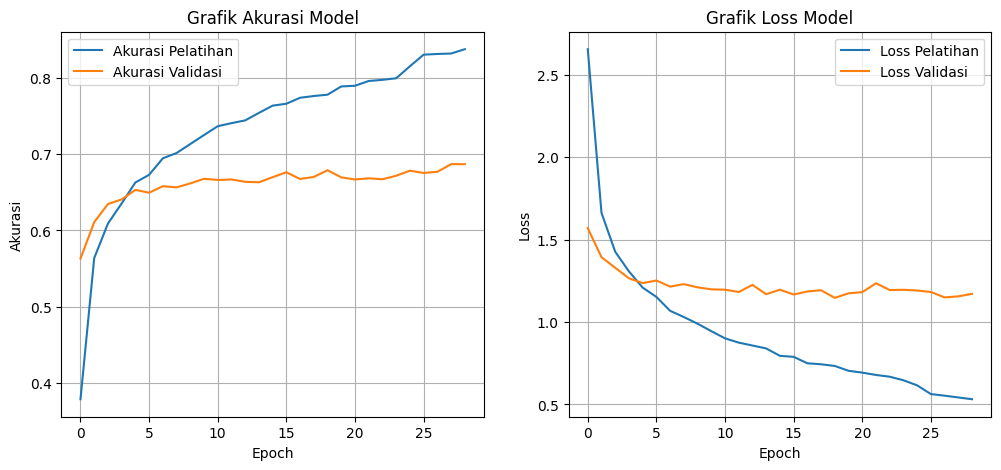


--- Membuat prediksi pada data testing untuk Laporan Klasifikasi ---
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step

Laporan Klasifikasi Detail:
                                precision    recall  f1-score   support

                  Afghan_hound       0.88      0.88      0.88        48
           African_hunting_dog       0.97      1.00      0.99        34
                      Airedale       0.68      0.70      0.69        40
American_Staffordshire_terrier       0.40      0.48      0.44        33
                   Appenzeller       0.50      0.50      0.50        30
            Australian_terrier       0.67      0.74      0.71        39
            Bedlington_terrier       0.91      0.89      0.90        36
          Bernese_mountain_dog       0.77      0.77      0.77        44
              Blenheim_spaniel       0.78      0.95      0.86        38
                 Border_collie       0.52      0.73      0.61        30
                Border_terrier       0.89      0.91      0.90   

In [11]:
print("--- Memulai evaluasi model ---")

# --- 6.1: Muat Kembali Model Terbaik ---
try:
    model.load_weights(checkpoint_path)
    print(f"Berhasil memuat bobot model terbaik dari: {checkpoint_path}")
except Exception as e:
    print(f"Gagal memuat bobot terbaik. Menggunakan model yang terakhir dilatih. Error: {e}")

# --- 6.2: Evaluasi Performa pada Data Testing ---
loss, accuracy = model.evaluate(test_generator)
print(f"\nHasil Evaluasi pada Data Testing:")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- 6.3: Visualisasi Hasil Pelatihan ---
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Grafik Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Grafik Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 6.4: Laporan Klasifikasi Detil ---
print("\n--- Membuat prediksi pada data testing untuk Laporan Klasifikasi ---")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

true_labels_names = [idx_to_class[i] for i in y_true]
predicted_labels_names = [idx_to_class[i] for i in y_pred]

print("\nLaporan Klasifikasi Detail:")
print(classification_report(true_labels_names, predicted_labels_names, target_names=list(idx_to_class.values())))

print("-" * 50)

In [12]:
print("--- Menyimpan model dan metadata ---")

# --- 7.1: Simpan Seluruh Model ---
# Menyimpan model dalam format .keras (format rekomendasi TensorFlow terbaru).
# Ini menyimpan arsitektur, bobot, dan konfigurasi optimizer.
model_save_path = 'dog_breed_classifier_final_model.keras'
model.save(model_save_path)
print(f"Model akhir berhasil disimpan ke: {model_save_path}")

# --- 7.2: Simpan Mapping Kelas ---
# Simpan dictionary 'idx_to_class' (indeks angka ke nama ras) ke file JSON.
# File ini sangat penting untuk antarmuka agar tahu nama ras yang sesuai dengan prediksi angka.
with open('class_indices.json', 'w') as f:
    json.dump(idx_to_class, f)
print(f"Mapping kelas berhasil disimpan ke: class_indices.json")

print("\nProses di Kaggle Notebook selesai.")
print("File yang perlu Anda unduh dari bagian 'Output' pada Kaggle Notebook adalah:")
print(f"- {model_save_path}")
print(f"- class_indices.json")

print("-" * 50)

--- Menyimpan model dan metadata ---
Model akhir berhasil disimpan ke: dog_breed_classifier_final_model.keras
Mapping kelas berhasil disimpan ke: class_indices.json

Proses di Kaggle Notebook selesai.
File yang perlu Anda unduh dari bagian 'Output' pada Kaggle Notebook adalah:
- dog_breed_classifier_final_model.keras
- class_indices.json
--------------------------------------------------
